# 10.3.  영어 한국어 Word2Vec 실습

gensim 패키지에 Word2Vec은 이미 구현되어 있습니다.

## 10.3.1. English

### 10.3.1.1. Data Understanding

링크 : https://wit3.fbk.eu/get.php?path=XML_releases/xml/ted_en-20160408.zip&filename=ted_en-20160408.zip

xml 파일을 가져옵니다. 전처리를 해야 합니다.

### 10.3.1.2. Preprocessing

In [1]:
import re
from lxml import etree
import urllib.request
import zipfile
from nltk.tokenize import word_tokenize, sent_tokenize

In [2]:
urllib.request.urlretrieve("https://wit3.fbk.eu/get.php?path=XML_releases/xml/ted_en-20160408.zip&filename=ted_en-20160408.zip", filename="ted_en-20160408.zip")
# 데이터 다운로드

with zipfile.ZipFile('ted_en-20160408.zip', 'r') as z:
    target_text = etree.parse(z.open('ted_en-20160408.xml', 'r'))
    parse_text = '\n'.join(target_text.xpath('//content/text()'))
# xml 파일로부터 <content>와 </content> 사이의 내용만 가져온다.

In [3]:
parse_text[:300]

"Here are two reasons companies fail: they only do more of the same, or they only do what's new.\nTo me the real, real solution to quality growth is figuring out the balance between two activities: exploration and exploitation. Both are necessary, but it can be too much of a good thing.\nConsider Facit"

전처리를 수행해봅시다.

In [4]:
# 정규표현식을 통해 기타 문자들 제거
content_text = re.sub(r'\([^)]*\)', '', parse_text)

# nltk를 이용하여 문장 토큰화
sent_text = sent_tokenize(content_text)

# 각 문장의 구두점 제거, 소문자로 변환
normalized_text = []
for string in sent_text:
    tokens = re.sub(r"[^a-z0-9]+", " ", string.lower())
    normalized_text.append(tokens)
    
# 각 문장에 대해서 nltk 이용하여 단어 토큰화 수행
result = [word_tokenize(sentence) for sentence in normalized_text]

In [5]:
# 총 샘플의 개수
print(len(result))

273424


In [6]:
# 샘플 3개만 추출

for line in result[:3]:
    print(line)

['here', 'are', 'two', 'reasons', 'companies', 'fail', 'they', 'only', 'do', 'more', 'of', 'the', 'same', 'or', 'they', 'only', 'do', 'what', 's', 'new']
['to', 'me', 'the', 'real', 'real', 'solution', 'to', 'quality', 'growth', 'is', 'figuring', 'out', 'the', 'balance', 'between', 'two', 'activities', 'exploration', 'and', 'exploitation']
['both', 'are', 'necessary', 'but', 'it', 'can', 'be', 'too', 'much', 'of', 'a', 'good', 'thing']


### 10.3.1.3. Training Word2Vec

In [7]:
from gensim.models import Word2Vec

In [8]:
model = Word2Vec(sentences=result,
                size=100, # 워드 벡터의 특징 값. 즉, 임베딩 된 벡터의 차원.
                window=5, # 컨텍스트 윈도우 크기.
                min_count=5, # 단어 최소 빈도 수 제한(빈도가 적은 단어들은 학습하지 않는다.)
                workers=4, # 학습을 위한 프로세스 수
                sg=0) # 0은 CBoW, 1은 Skip-gram

Word2Vec은 입력한 단어에 대해 가장 유사한 단어들을 출력하는 model.wv.most_similar를 지원합니다.

In [9]:
model_result = model.wv.most_similar("man")
print(model_result)

[('woman', 0.8585288524627686), ('guy', 0.8139721155166626), ('lady', 0.7843915820121765), ('girl', 0.7614036798477173), ('boy', 0.7594757080078125), ('gentleman', 0.7481688261032104), ('soldier', 0.7418292760848999), ('kid', 0.710865318775177), ('poet', 0.7055411338806152), ('writer', 0.6627633571624756)]


### 10.3.1.4. Model save and load

공들여 학습한 모델은 언제든 나중에 다시 사용할 수 있도록 컴퓨터 파일로 저장하고 다시 로드해보겠습니다.

In [10]:
from gensim.models import KeyedVectors

In [11]:
model.wv.save_word2vec_format('eng_w2v') # 모델 저장
loaded_model = KeyedVectors.load_word2vec_format("eng_w2v") #모델 로드

In [12]:
# 로드한 모델로 출력 해보겠습니다.
model_result = loaded_model.most_similar("woman")
print(model_result)

[('man', 0.858528733253479), ('girl', 0.8523677587509155), ('lady', 0.8222741484642029), ('boy', 0.7946901321411133), ('kid', 0.7542577981948853), ('child', 0.7482434511184692), ('guy', 0.7270610332489014), ('soldier', 0.7268799543380737), ('gentleman', 0.7152020931243896), ('poet', 0.6952031850814819)]


## 10.3.2. Korean Word2Vec_네이버영화리뷰

In [14]:
import urllib.request
from konlpy.tag import Okt
from gensim.models.word2vec import Word2Vec
import pandas as pd
import matplotlib.pyplot as plt

네이버 영화 리뷰를 해보겠습니다!

In [15]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")

('ratings.txt', <http.client.HTTPMessage at 0x1f7df5d8240>)

In [16]:
train_data = pd.read_table("ratings.txt")

In [17]:
train_data[:5]

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [18]:
print(len(train_data))

200000


In [19]:
# NULL값 존재 유무
print(train_data.isnull().values.any())

True


In [20]:
train_data = train_data.dropna(how='any')
print(train_data.isnull().values.any())

False


In [21]:
print(len(train_data))

199992


In [22]:
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

In [23]:
train_data[:5]

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,디자인을 배우는 학생으로 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업...,1
2,4655635,폴리스스토리 시리즈는 부터 뉴까지 버릴께 하나도 없음 최고,1
3,9251303,와 연기가 진짜 개쩔구나 지루할거라고 생각했는데 몰입해서 봤다 그래 이런게 진짜 영화지,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화,1


In [24]:
# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [25]:
#  토큰화

okt = Okt()
tokenized_data = []
for sentence in train_data['document']:
    temp_x = okt.morphs(sentence, stem=True) # 토큰화
    temp_x = [word for word in temp_x if not word in stopwords] # 불용어 제거
    tokenized_data.append(temp_x)

리뷰의 최대 길이 : 72
리뷰의 평균 길이 : 10.716703668146726


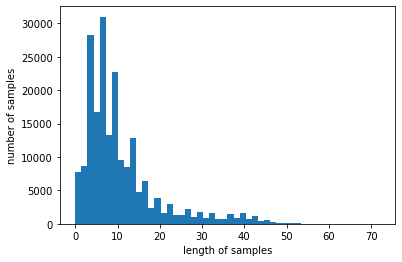

In [26]:
# 리뷰 길이 분포 확인
print('리뷰의 최대 길이 :',max(len(l) for l in tokenized_data))
print('리뷰의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(s) for s in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [27]:
from gensim.models import Word2Vec

In [28]:
model = Word2Vec(sentences = tokenized_data,
                size = 100,
                window = 5,
                min_count = 5,
                workers = 4,
                sg = 0)

In [29]:
# 완성된 임베딩 매트릭스의 크기 확인.

model.wv.vectors.shape

(16477, 100)

In [30]:
print(model.wv.most_similar("최민식"))

[('한석규', 0.8573399782180786), ('최민수', 0.8522400856018066), ('안성기', 0.8446011543273926), ('박중훈', 0.8420392274856567), ('이민호', 0.8398627042770386), ('설경구', 0.8321352005004883), ('김수현', 0.8254207968711853), ('송강호', 0.8220459222793579), ('윤제문', 0.8211894631385803), ('이미숙', 0.8202099204063416)]


In [31]:
print(model.wv.most_similar("호러"))

[('무협', 0.8910517692565918), ('느와르', 0.8649859428405762), ('슬래셔', 0.8614627122879028), ('블록버스터', 0.8577938079833984), ('정통', 0.8504294157028198), ('히어로', 0.8452297449111938), ('멜로', 0.8406030535697937), ('컬트', 0.8243943452835083), ('판타지', 0.8241962194442749), ('무비', 0.8210760354995728)]


## 10.3.3. Korean Word2Vec_위키피디아

### 10.3.3.1. 위키피디아 한국어 덤프 파일 다운로드

https://dumps.wikimedia.org/kowiki/latest/

여기서 kowiki-latest-pages-articles.xml.bz2 파일입니다. 해당 파일은 xml 파일므로, Word2Vec을 원활하게 진행하기 위해 파일 형식을 변환해줄 필요가 있습니다.

### 10.3.3.2. 위키피디아 익스트랙터 다운로드

cmd 에서

git clone "https://github.com/attardi/wikiextractor.git"

으로 클로닝해줍니다.

### 10.3.3.3. 위키피디아 한국어 덤프 파일 변환

덤프 파일과 익스트랙터를 동일한 경로에 두고

python WikiExtractor.py kowiki-latest-pages-articles.xml.bz2  

cmd에서 해당 경로에서 위 명령어를 쓰면 약 10분 정도 덤프를 텍스트로 변환합니다.

### 10.3.3.4. 훈련 데이터 만들기

우선 AA 디렉토리 안의 모든 파일인 wiki00 ~ wiki90에 대해서 wikiAA.txt로 통합해보겠습니다. 프롬프트에서 아래의 커맨드를 수행합니다.

copy AA디렉토리의 경로\wiki* wikiAA.txt

다른 디렉토리에 대해서도 동일하게 진행

- copy AB디렉토리의 경로\wiki* wikiAB.txt
- copy AC디렉토리의 경로\wiki* wikiAC.txt
- copy AD디렉토리의 경로\wiki* wikiAD.txt
- copy AE디렉토리의 경로\wiki* wikiAE.txt
- copy AF디렉토리의 경로\wiki* wikiAF.txt

그 여섯개도 하나로 합치기

- copy 현재 디렉토리의 경로\wikiA* wiki_data.txt

### 10.3.3.5. 훈련 데이터 전처리 학기

In [5]:
f = open(r'C:\Users\thinp\python\Study\Beginning NLP with DeepLearning_20.07\wikiextractor\wiki_data.text',
         encoding="utf8")

In [6]:
i=0
while True:
    line = f.readline()
    if line != '\n':
        i +=1
        print("%d번째 줄: "%i + line)
    if i ==5:
        break
f.close()

1번째 줄: <doc id="5" url="https://ko.wikipedia.org/wiki?curid=5" title="지미 카터">

2번째 줄: 지미 카터

3번째 줄: 제임스 얼 "지미" 카터 주니어(, 1924년 10월 1일 ~ )는 민주당 출신 미국 39번째 대통령 (1977년 ~ 1981년)이다.

4번째 줄: 지미 카터는 조지아주 섬터 카운티 플레인스 마을에서 태어났다. 조지아 공과대학교를 졸업하였다. 그 후 해군에 들어가 전함·원자력·잠수함의 승무원으로 일하였다. 1953년 미국 해군 대위로 예편하였고 이후 땅콩·면화 등을 가꿔 많은 돈을 벌었다. 그의 별명이 "땅콩 농부" (Peanut Farmer)로 알려졌다.

5번째 줄: 1962년 조지아 주 상원 의원 선거에서 낙선하나 그 선거가 부정선거 였음을 입증하게 되어 당선되고, 1966년 조지아 주 지사 선거에 낙선하지만 1970년 조지아 주 지사를 역임했다. 대통령이 되기 전 조지아주 상원의원을 두번 연임했으며, 1971년부터 1975년까지 조지아 지사로 근무했다. 조지아 주지사로 지내면서, 미국에 사는 흑인 등용법을 내세웠다.



본격적인 전처리를 시작하겠습니다.

In [7]:
from konlpy.tag import Okt

In [8]:
okt = Okt()
fread=open(r'C:\Users\thinp\python\Study\Beginning NLP with DeepLearning_20.07\wikiextractor\wiki_data.text',
         encoding="utf8")

In [ ]:
n = 0
result = []

while True:
    line = fread.readline() #  한 줄씩 리드
    if not line:
        break # 모두 읽으면 종료
    n+=1
    if n%5000 == 0: # 5,000의 배수로 while문이 실행될 때마다 몇 번째 while 문인지 출력
        print("%d th while. "%n)
    
    tokenlist = okt.pos(line, stem=True, norm=True) # 토큰화
    temp = []
    for word in tokenlist:
        if word[1] in ["Noun"]: # 명사일 때만
            temp.append((word[0])) # 해당 단어를 저장
        
    if temp: #명사가 존재하면
        result.append(temp) # 결과에 저장
        
fread.close()

5000 th while. 
10000 th while. 
15000 th while. 
20000 th while. 
25000 th while. 
30000 th while. 
35000 th while. 
40000 th while. 
45000 th while. 
50000 th while. 
55000 th while. 
60000 th while. 
65000 th while. 
70000 th while. 
75000 th while. 
80000 th while. 
85000 th while. 
90000 th while. 
95000 th while. 
100000 th while. 
105000 th while. 
110000 th while. 
115000 th while. 
120000 th while. 
125000 th while. 
130000 th while. 
135000 th while. 
140000 th while. 
145000 th while. 
150000 th while. 
155000 th while. 
160000 th while. 
165000 th while. 
170000 th while. 
175000 th while. 
180000 th while. 
185000 th while. 
190000 th while. 
195000 th while. 
200000 th while. 
205000 th while. 
210000 th while. 
215000 th while. 
220000 th while. 
225000 th while. 
230000 th while. 
235000 th while. 
240000 th while. 
245000 th while. 
250000 th while. 
255000 th while. 
260000 th while. 
265000 th while. 
270000 th while. 
275000 th while. 
280000 th while. 
285000 th wh

In [ ]:
print("Count of Samples: {}".format(len(result)))

### 10.3.3.6. Word2Vec Training

In [ ]:
from gensim.models import Word2Vec

In [ ]:
model = Word2Vec(result,
                size=100,
                window=5,
                min_count=5,
                workers=4,
                sg=0)

## 10.3.4. 사전 훈련된 Word2Vec 임베딩 소개

사전 훈련된 모델이 있다고 합니다. 가져와서 써도 좋습니다.

https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit

용량이 3기가가 넘기 때문에 돌려보진 않겠습니다.

https://drive.google.com/file/d/0B0ZXk88koS2KbDhXdWg1Q2RydlU/view

박병규님의 한국어 프리트레인 모델입니다. 이것만 해보죠

In [1]:
import gensim

In [3]:
model = gensim.models.Word2Vec.load(r"C:\Users\thinp\python\Study\Beginning NLP with DeepLearning_20.07\ko\ko.bin")

In [4]:
result = model.wv.most_similar("강아지")
print(result)

[('고양이', 0.7290453314781189), ('거위', 0.7185634970664978), ('토끼', 0.7056223750114441), ('멧돼지', 0.6950401067733765), ('엄마', 0.693433403968811), ('난쟁이', 0.6806551218032837), ('한마리', 0.6770296096801758), ('아가씨', 0.675035297870636), ('아빠', 0.6729634404182434), ('목걸이', 0.6512461304664612)]


# 10.4. Word2Vec 구현하기(Skip-Gram)

이번 챕터에서는 네거티브 샘플링을 사용하는 Word2Vec을 케라스로 구현해봅니다.

## 10.4.1. 네거티브 샘플링을 사용한 Skip-Gram

http://jalammar.github.io/illustrated-word2vec/

이론은 여기서 보시면 됩니다. 영어주의입니다.

## 10.4.2. 20뉴스그룹 데이터 전처리

In [6]:
from sklearn.datasets import fetch_20newsgroups
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [7]:
# 하나의 샘플에 최소 단어 2개는 있어야 합니다.
# 그래야 중심단어, 주변단어의 관계가 성립합니다.
# 이를 만족하지 않는 샘플은 전처리에서 제거합니다.

dataset = fetch_20newsgroups(shuffle = True,
                            random_state=1,
                            remove=('headers',
                                   'footers',
                                   'quotes'))
documents=dataset.data
print(len(documents))

11314


In [8]:
# 총 샘플 수는 11,314개
# 전처리를 진행합니다.
# 불필요한 토큰 제거하고, 정규화 합니다.

news_df = pd.DataFrame({'document':documents})

# 정규식
news_df['clean_doc']  = news_df['document'].str.replace("[^a-zA-Z]", " ")

# 길이가 3이하인 단어 제거
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 3]))

# 소문자  변환
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: x.lower())

In [9]:
# 결측값 확인

news_df.isnull().values.any()

False

In [10]:
# 빈 값 유무 확인

news_df.replace("", float("NaN"), inplace=True)
news_df.isnull().values.any()

True

In [11]:
# 있네요.

news_df.dropna(inplace=True)
print(len(news_df))

10995


In [13]:
# 약 300개 나가리

# 불용어 제거
stop_words = stopwords.words('english')
tokenized_doc = news_df['clean_doc'].apply(lambda x: x.split())
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])
tokenized_doc = tokenized_doc.to_list()

In [14]:
# 단어가 한 개 이하인 경우 찾아서 제거

drop_train = [index for index, sentence in enumerate(tokenized_doc) if len(sentence) <= 1]
tokenized_doc = np.delete(tokenized_doc, drop_train, axis=0)
print(len(tokenized_doc))

10940


In [16]:
# 단어 집합을 생성하고 정수 인코딩

tokenizer = Tokenizer()
tokenizer.fit_on_texts(tokenized_doc)

word2idx = tokenizer.word_index
idx2word = {v:k for k, v in word2idx.items()}
encoded = tokenizer.texts_to_sequences(tokenized_doc)

In [17]:
print(encoded[:2])

[[9, 59, 603, 207, 3278, 1495, 474, 702, 9470, 13686, 5533, 15227, 702, 442, 702, 70, 1148, 1095, 1036, 20294, 984, 705, 4294, 702, 217, 207, 1979, 15228, 13686, 4865, 4520, 87, 1530, 6, 52, 149, 581, 661, 4406, 4988, 4866, 1920, 755, 10668, 1102, 7837, 442, 957, 10669, 634, 51, 228, 2669, 4989, 178, 66, 222, 4521, 6066, 68, 4295], [1026, 532, 2, 60, 98, 582, 107, 800, 23, 79, 4522, 333, 7838, 864, 421, 3825, 458, 6488, 458, 2700, 4730, 333, 23, 9, 4731, 7262, 186, 310, 146, 170, 642, 1260, 107, 33568, 13, 985, 33569, 33570, 9471, 11491]]


In [27]:
vocab_size = len(word2idx) + 1
print(vocab_size)

64277


## 10.4.3. 네거티브 샘플링을 통한 데이터셋 구성하기

토큰화, 정제, 정규화, 불용어 제거, 정수 인코딩까지 일반적인 전처리 과정을 거쳤습니다.

네거티브 샘플링을 통한 데이터셋을 구성할 차례입니다. 케라스의 skipgrams를 사용합니다.

In [28]:
from keras.preprocessing.sequence import skipgrams

In [29]:
skip_grams = [skipgrams(sample,
                        vocabulary_size=vocab_size,
                       window_size=10) for sample in encoded[:10]]

In [30]:
# 첫 번째 샘플인 skip_grams[0] 내 skipgrams로 형성된 데이터셋 확인
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(5):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(idx2word[pairs[i][0]],
                                                      pairs[i][0],
                                                      idx2word[pairs[i][1]],
                                                      pairs[i][1],
                                                      labels[i]))

(away (178), equality (11862)) -> 0
(media (702), dowry (36585)) -> 0
(degree (1530), shame (4988)) -> 1
(seem (207), burzynski (10009)) -> 0
(world (70), eaven (48964)) -> 0


윈도우 크기 내에서 중심 단어, 주변 단어의 관계를 가지는 경우에는 1의 레이블을 갖도록 하고, 그렇지 않은 경우에는 0의 레이블을 가지도록 데이터셋을 구성합니다.

In [31]:
print('전체 샘플 수 :',len(skip_grams))

전체 샘플 수 : 10


encoded 중 상위 10개의 뉴스그룹 샘플에 대해서만 수행하였으므로 10이 출력됩니다.

In [32]:
# 첫번째 뉴스그룹 샘플에 대해서 생긴 pairs와 labels의 개수
print(len(pairs))
print(len(labels))

2220
2220


In [33]:
# 이 작업을 모든 뉴스그룹 샘플에 대해서 수행합니다.

skip_grams = [skipgrams(sample,
                        vocabulary_size=vocab_size,
                        window_size=10) for sample in encoded]

## 10.4.4. SGNS(Skip-Gram with Negative Sampling) 구현

Skip-Gram을 직접 구현해봅니다.

In [44]:
from keras.models import Sequential, Model
from keras.layers import Embedding, Reshape, Activation, Input
from keras.layers import Dot
from keras.utils import plot_model
from IPython.display import SVG
import pydot

In [36]:
# 임베딩 차원은 100으로 하겠습니다.

embed_size = 100

In [37]:
# 모델을 설계하겠습니다. 우선, 두 개의 임베딩 테이블을 생성합니다.

# 중심 단어를 위한 임베딩 테이블
w_inputs = Input(shape=(1, ), dtype='int32')
word_embedding = Embedding(vocab_size, embed_size)(w_inputs)

# 주변 단어를 위한 임베딩 테이블
c_inputs = Input(shape=(1, ), dtype='int32')
context_embedding = Embedding(vocab_size, embed_size)(c_inputs)

In [38]:
# 각 임베딩 테이블은 중심 단어와 주변 단어 각각을 위한 임베딩 테이블이며
# 각 단어는 임베딩 테이블을 거쳐서 내적을 수행
# 내적의 결과는 1 또는 0을 예측하기 위해서 시그모이드 함수를 활성화 함수로 거쳐 최종 예측 값 득

dot_product = Dot(axes=2)([word_embedding, context_embedding])
dot_product = Reshape((1, ), input_shape=(1, 1))(dot_product)
output = Activation('sigmoid')(dot_product)

In [39]:
model = Model(inputs=[w_inputs, c_inputs], outputs=output)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 100)       6427700     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 100)       6427700     input_2[0][0]                    
____________________________________________________________________________________________

In [40]:
model.compile(loss='binary_crossentropy', optimizer='adam')

In [48]:
plot_model(model, to_file='model3.png', show_shapes=True, show_layer_names=True, rankdir='TB')

ImportError: Failed to import `pydot`. Please install `pydot`. For example with `pip install pydot`.

In [49]:
for epoch in range(1, 6):
    loss = 0
    for _, elem in enumerate(skip_grams):
        first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
        second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
        labels = np.array(elem[1], dtype='int32')
        X = [first_elem, second_elem]
        Y = labels
        loss += model.train_on_batch(X, Y)
    print('Epoch: ', epoch, 'Loss: ', loss)
    
    # 너무 오래 걸려요.

C:\Users\thinp\anaconda3\envs\Wyatt37\lib\site-packages\tensorflow\python\framework\indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


KeyboardInterrupt: 

# 10.5.  GloVe( 글로브)

글로브(Global Vectors for Word Representation, GloVe)는 카운트 기반과 예측 기반을 모두 사용하는 방법론으로 2014년에 미국 스탠포드대학에서 개발한 단어 임베딩 방법론이다. 카운트 기반의 LSA와 예측 기반의 Word2Vec의 단점을 보완한 방법론으로 실제로 Word2Vec만큼 뛰어난 성능을 보인다. GloVe와 Word2Vec의 성능은 비등비등하며 비교사용하면 된다.

이론은 이러하다. LSA가 카운트 기반으로 전체적인 통계 정보를 고려하기는 하지만, 단어 의미의 유추 작업에는 성능이 떨어진다. 반면 Word2Vec은 예측 기반이기 때문에 단어 간 유추 작업에는 뛰어나지만, 임베딩 벡터가 윈도우 크기 내에서만 주변 단어를 고려하기 때문에 코퍼스의 전체적인 통계 정보를 반영하지 못한다. 글로브는 이러한 두 방법론의 단점을 보완하기 위해 두 방법론을 모두 사용한다.

설치가 안돼요...1시간 날렸네..

# 10.6. 사전 훈련된 워드 임베딩(Pre-trained Word Embedding)

요번 챕터에서는 케라스의 임베딩 층과 사전 훈련된 워드 임베딩을 가져와서 사용하는 것을 비교해봅니다.

## 10.6.1. 케라스 임베딩 층(Keras Embedding Layer)

케라스의 임베딩층은 입력 정수에 대해 밀집 벡터로 맵핑하고 이 밀집 벡터는 인공 신경망의 학습 과정에서 가중치가 학습되는 것과 같은 방식으로 훈련됩니다.

임베딩 층은 다음과 같은 세 개의 인자를 받습니다.

- vocab_size: 텍스트 데이터의 전체 단어 집합의 크기
- output_dim: 워드 임베딩 후의 임베딩 벡터의 차원
- input_length: 입력 시퀀스의 길이

In [1]:
import keras

In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

In [3]:
# 예시로 대충 문장과 레이블 데이터를 만듭니다. 긍정이 1 부정이 0입니다.

sentences = ['nice great best amazing', 'stop lies',
             'pitiful nerd', 'excellent work', 'supreme quality',
             'bad', 'highly respectable']
y_train = [1, 0, 0, 1, 1, 0, 1]

In [4]:
# 가장 먼저 토큰화를 시킵니다.

t = Tokenizer()
t.fit_on_texts(sentences)
vocab_size = len(t.word_index) + 1

print(vocab_size)

16


In [6]:
# 문장에 대한 정수 인코딩을 실시합니다.

X_encoded = t.texts_to_sequences(sentences)
print(X_encoded)

[[1, 2, 3, 4], [5, 6], [7, 8], [9, 10], [11, 12], [13], [14, 15]]


In [7]:
max_len = max(len(l) for l in X_encoded)
print(max_len)

4


In [8]:
# 문장의 길이가 동일하게 패딩을 해주어야 합니다.

X_train = pad_sequences(X_encoded, maxlen=max_len, padding='post')
y_train = np.array(y_train)
print(X_train)

[[ 1  2  3  4]
 [ 5  6  0  0]
 [ 7  8  0  0]
 [ 9 10  0  0]
 [11 12  0  0]
 [13  0  0  0]
 [14 15  0  0]]


전처리가 끝났습니다. 모델링 시작합니다.

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Flatten

In [10]:
model = Sequential()

In [11]:
model.add(Embedding(vocab_size, 4, input_length=max_len)) # 4차원 벡터
model.add(Flatten()) # 1차원으로 짜부
model.add(Dense(1, activation='sigmoid')) # 1차원 인풋

In [12]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

In [13]:
model.fit(X_train, y_train, epochs=100, verbose=2)

C:\Users\thinp\anaconda3\envs\Wyatt37\lib\site-packages\tensorflow\python\framework\indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
 - 0s - loss: 0.6934 - acc: 0.4286
Epoch 2/100
 - 0s - loss: 0.6918 - acc: 0.5714
Epoch 3/100
 - 0s - loss: 0.6905 - acc: 0.5714
Epoch 4/100
 - 0s - loss: 0.6889 - acc: 0.7143
Epoch 5/100
 - 0s - loss: 0.6873 - acc: 0.7143
Epoch 6/100
 - 0s - loss: 0.6858 - acc: 0.7143
Epoch 7/100
 - 0s - loss: 0.6842 - acc: 0.7143
Epoch 8/100
 - 0s - loss: 0.6827 - acc: 0.7143
Epoch 9/100
 - 0s - loss: 0.6811 - acc: 0.7143
Epoch 10/100
 - 0s - loss: 0.6795 - acc: 0.7143
Epoch 11/100
 - 0s - loss: 0.6780 - acc: 0.8571
Epoch 12/100
 - 0s - loss: 0.6764 - acc: 1.0000
Epoch 13/100
 - 0s - loss: 0.6748 - acc: 1.0000
Epoch 14/100
 - 0s - loss: 0.6732 - acc: 1.0000
Epoch 15/100
 - 0s - loss: 0.6716 - acc: 1.0000
Epoch 16/100
 - 0s - loss: 0.6700 - acc: 1.0000
Epoch 17/100
 - 0s - loss: 0.6683 - acc: 1.0000
Epoch 18/100
 - 0s - loss: 0.6667 - acc: 1.0000
Epoch 19/100
 - 0s - loss: 0.6651 - acc: 1.0000
Epoch 20/100
 - 0s - loss: 0.6634 - acc: 1.0000
Epoch 21/100
 - 0s - loss: 0.6618 - acc: 1.0000
E

뭐 대충 요렇게 돌아간다 라고 보시면 됩니다.

## 10.6.2. 사전 훈련된 워드 임베딩(Pre-Trained Word Embedding) 사용하기

임베딩 벡터를 얻기 위해서 케라스의 Embedding()을 사용하기도 하지만, 때로는 이미 훈련되어져 있는 워드 임베딩을 불러서 이를 임베딩 벡터로 사용하기도 합니다.

훈련 데이터가 적은 상황이라면 모델에 케라스의 Embedding()을 사용하는 것보다 다른 텍스트 데이터로 사전 훈련되어 있는 임베딩 벡터를 불러오는 것이 나은 선택일 수 이씃ㅂ니다.

- GloVe 다운로드 링크 : http://nlp.stanford.edu/data/glove.6B.zip
- Word2Vec 다운로드 링크 : https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM

훈련 데이터는 앞서 사용하였던 데이터를 쓰겠습니다.

In [14]:
print(X_train)

[[ 1  2  3  4]
 [ 5  6  0  0]
 [ 7  8  0  0]
 [ 9 10  0  0]
 [11 12  0  0]
 [13  0  0  0]
 [14 15  0  0]]


In [15]:
print(y_train)

[1 0 0 1 1 0 1]


### 10.6.2.1. 사전 훈련된 Word2Vec 사용하기

In [16]:
import numpy as np
import gensim

C:\Users\thinp\anaconda3\envs\Wyatt37\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\thinp\anaconda3\envs\Wyatt37\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [17]:
# 구글의 사전 훈련된 Word2Vec 모델 로드

word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

In [19]:
print(word2vec_model.vectors.shape)

(3000000, 300)


300차원을 가진 300만개의 벡터가 있습니다.

In [21]:
# 단어가 16개 이므로 16 x 300 의 영행렬을 만들어줍니다.

embedding_matrix  = np.zeros((vocab_size, 300))
np.shape(embedding_matrix)

(16, 300)

In [22]:
# word2vec_model 에서 특정 단어를 입력하면 해당 단어의 임베딩 벡터를 리턴 받고,
# 만약 word2vec_model에 임베딩 벡터가 없다면 None을 리턴합니다.

def get_vector(word):
    if word in word2vec_model:
        return word2vec_model[word]
    else:
        return None

In [23]:
for word, i in t.word_index.items(): # .items()는 dic의 키밸류를 리스트화
    temp = get_vector(word)
    if temp is not None:
        embedding_matrix[i] = temp

In [28]:
print(word2vec_model['nice'])

[ 0.15820312  0.10595703 -0.18945312  0.38671875  0.08349609 -0.26757812
  0.08349609  0.11328125 -0.10400391  0.17871094 -0.12353516 -0.22265625
 -0.01806641 -0.25390625  0.13183594  0.0859375   0.16113281  0.11083984
 -0.11083984 -0.0859375   0.0267334   0.34570312  0.15136719 -0.00415039
  0.10498047  0.04907227 -0.06982422  0.08642578  0.03198242 -0.02844238
 -0.15722656  0.11865234  0.36132812  0.00173187  0.05297852 -0.234375
  0.11767578  0.08642578 -0.01123047  0.25976562  0.28515625 -0.11669922
  0.38476562  0.07275391  0.01147461  0.03466797  0.18164062 -0.03955078
  0.04199219  0.01013184 -0.06054688  0.09765625  0.06689453  0.14648438
 -0.12011719  0.08447266 -0.06152344  0.06347656  0.3046875  -0.35546875
 -0.2890625   0.19628906 -0.33203125 -0.07128906  0.12792969  0.09619141
 -0.12158203 -0.08691406 -0.12890625  0.27734375  0.265625    0.1796875
  0.12695312  0.06298828 -0.34375    -0.05908203  0.0456543   0.171875
  0.08935547  0.14648438 -0.04638672 -0.00842285 -0.0279

In [29]:
print('단어 nice의 정수 인덱스 :', t.word_index['nice'])

단어 nice의 정수 인덱스 : 1


In [30]:
print(embedding_matrix[1])

[ 0.15820312  0.10595703 -0.18945312  0.38671875  0.08349609 -0.26757812
  0.08349609  0.11328125 -0.10400391  0.17871094 -0.12353516 -0.22265625
 -0.01806641 -0.25390625  0.13183594  0.0859375   0.16113281  0.11083984
 -0.11083984 -0.0859375   0.0267334   0.34570312  0.15136719 -0.00415039
  0.10498047  0.04907227 -0.06982422  0.08642578  0.03198242 -0.02844238
 -0.15722656  0.11865234  0.36132812  0.00173187  0.05297852 -0.234375
  0.11767578  0.08642578 -0.01123047  0.25976562  0.28515625 -0.11669922
  0.38476562  0.07275391  0.01147461  0.03466797  0.18164062 -0.03955078
  0.04199219  0.01013184 -0.06054688  0.09765625  0.06689453  0.14648438
 -0.12011719  0.08447266 -0.06152344  0.06347656  0.3046875  -0.35546875
 -0.2890625   0.19628906 -0.33203125 -0.07128906  0.12792969  0.09619141
 -0.12158203 -0.08691406 -0.12890625  0.27734375  0.265625    0.1796875
  0.12695312  0.06298828 -0.34375    -0.05908203  0.0456543   0.171875
  0.08935547  0.14648438 -0.04638672 -0.00842285 -0.0279

두 임베딩 벡터 값이 동일하므로 잘 맵핑된 것을 알 수 있습니다. 이제 학습을 하겠습니다.

In [31]:
model = Sequential()

In [32]:
e = Embedding(vocab_size,
              300,
              weights=[embedding_matrix],
              input_length=max_len,
              trainable=False)

In [34]:
model.add(e)
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [35]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['acc'])

In [36]:
model.fit(X_train, y_train, epochs=100, verbose=2)

Epoch 1/100
 - 0s - loss: 0.7169 - acc: 0.2857
Epoch 2/100
 - 0s - loss: 0.6977 - acc: 0.2857
Epoch 3/100
 - 0s - loss: 0.6790 - acc: 0.5714
Epoch 4/100
 - 0s - loss: 0.6610 - acc: 0.5714
Epoch 5/100
 - 0s - loss: 0.6434 - acc: 0.8571
Epoch 6/100
 - 0s - loss: 0.6265 - acc: 0.8571
Epoch 7/100
 - 0s - loss: 0.6101 - acc: 1.0000
Epoch 8/100
 - 0s - loss: 0.5942 - acc: 1.0000
Epoch 9/100
 - 0s - loss: 0.5791 - acc: 1.0000
Epoch 10/100
 - 0s - loss: 0.5643 - acc: 1.0000
Epoch 11/100
 - 0s - loss: 0.5501 - acc: 1.0000
Epoch 12/100
 - 0s - loss: 0.5364 - acc: 1.0000
Epoch 13/100
 - 0s - loss: 0.5230 - acc: 1.0000
Epoch 14/100
 - 0s - loss: 0.5102 - acc: 1.0000
Epoch 15/100
 - 0s - loss: 0.4977 - acc: 1.0000
Epoch 16/100
 - 0s - loss: 0.4858 - acc: 1.0000
Epoch 17/100
 - 0s - loss: 0.4742 - acc: 1.0000
Epoch 18/100
 - 0s - loss: 0.4631 - acc: 1.0000
Epoch 19/100
 - 0s - loss: 0.4523 - acc: 1.0000
Epoch 20/100
 - 0s - loss: 0.4418 - acc: 1.0000
Epoch 21/100
 - 0s - loss: 0.4317 - acc: 1.0000
E

### 10.6.2.2. 사전 훈련된 GloVe 사용하기

우선 다운로드 받은 파일인 glove.6B.zip의 압축을 풀면 그 안에 4개의 파일이 있는데 여기서 사용할 파일은 glove.6B.100d.txt 파일입니다. 해당 파일은 하나의 줄당 101개의 값을 가지는 리스트를 갖고 있습니다. 두 개의 줄만 읽어보도록 하겠습니다.

In [37]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [38]:
n=0
f = open('glove.6B.100d.txt', encoding="utf8")

In [39]:
for line in f:
    word_vector = line.split() # 각 줄을 읽어와서 word_vector에 저장.
    print(word_vector) # 각 줄을 출력
    word = word_vector[0] # word_vector에서 첫 번째 값만 저장
    print(word) # word_vector의 첫 번째 값만 출력
    n+=1
    if n==2:
        break
f.close()

['the', '-0.038194', '-0.24487', '0.72812', '-0.39961', '0.083172', '0.043953', '-0.39141', '0.3344', '-0.57545', '0.087459', '0.28787', '-0.06731', '0.30906', '-0.26384', '-0.13231', '-0.20757', '0.33395', '-0.33848', '-0.31743', '-0.48336', '0.1464', '-0.37304', '0.34577', '0.052041', '0.44946', '-0.46971', '0.02628', '-0.54155', '-0.15518', '-0.14107', '-0.039722', '0.28277', '0.14393', '0.23464', '-0.31021', '0.086173', '0.20397', '0.52624', '0.17164', '-0.082378', '-0.71787', '-0.41531', '0.20335', '-0.12763', '0.41367', '0.55187', '0.57908', '-0.33477', '-0.36559', '-0.54857', '-0.062892', '0.26584', '0.30205', '0.99775', '-0.80481', '-3.0243', '0.01254', '-0.36942', '2.2167', '0.72201', '-0.24978', '0.92136', '0.034514', '0.46745', '1.1079', '-0.19358', '-0.074575', '0.23353', '-0.052062', '-0.22044', '0.057162', '-0.15806', '-0.30798', '-0.41625', '0.37972', '0.15006', '-0.53212', '-0.2055', '-1.2526', '0.071624', '0.70565', '0.49744', '-0.42063', '0.26148', '-1.538', '-0.30223

In [40]:
print(type(word_vector))
print(len(word_vector))

<class 'list'>
101


101개의 값 중에서 첫번째 값은 임베딩 벡터가 의미하는 단어를 의미하며, 두번째 값부터 마지막 값은 해당 단어의 임베딩 벡터의 100개의 차원에서의 각 값을 의미합니다. 즉, glove.6B.100d.txt는 수많은 단어에 대해서 100개의 차원을 가지는 임베딩 벡터로 제공하고 있습니다. 위의 출력 결과는 단어 'the'에 대해서 100개의 차원을 가지는 임베딩 벡터와 단어 ','에 대해서 100개의 차원을 가지는 임베딩 벡터를 보여줍니다.

In [41]:
# 모든 값을 불러와봅니다.

embedding_dict = dict()
f = open('glove.6B.100d.txt', encoding="utf8")

for line in f:
    word_vector = line.split()
    word = word_vector[0]
    word_vector_arr = np.asarray(word_vector[1:], dtype='float32')
    # 100개의 값을 가지는 array로 변환
    embedding_dict[word] = word_vector_arr
    # 키, 밸류(어레이) 로 할당.

f.close()
print(len(embedding_dict))

400000


샘플 가져와보겠습니다.

In [42]:
print(embedding_dict['respectable'])
print(len(embedding_dict['respectable']))

[-0.049773   0.19903    0.10585    0.1391    -0.32395    0.44053
  0.3947    -0.22805   -0.25793    0.49768    0.15384   -0.08831
  0.0782    -0.8299    -0.037788   0.16772   -0.45197   -0.17085
  0.74756    0.98256    0.81872    0.28507    0.16178   -0.48626
 -0.006265  -0.92469   -0.30625   -0.067318  -0.046762  -0.76291
 -0.0025264 -0.018795   0.12882   -0.52457    0.3586     0.43119
 -0.89477   -0.057421  -0.53724    0.25587    0.55195    0.44698
 -0.24252    0.29946    0.25776   -0.8717     0.68426   -0.05688
 -0.1848    -0.59352   -0.11227   -0.57692   -0.013593   0.18488
 -0.32507   -0.90171    0.17672    0.075601   0.54896   -0.21488
 -0.54018   -0.45882   -0.79536    0.26331    0.18879   -0.16363
  0.3975     0.1099     0.1164    -0.083499   0.50159    0.35802
  0.25677    0.088546   0.42108    0.28674   -0.71285   -0.82915
  0.15297   -0.82712    0.022112   1.067     -0.31776    0.1211
 -0.069755  -0.61327    0.27308   -0.42638   -0.085084  -0.17694
 -0.0090944  0.1109     0.

In [44]:
embedding_matrix = np.zeros((vocab_size, 100))
np.shape(embedding_matrix)
# 영행렬을 만들어줍니다.

(16, 100)

In [45]:
print(t.word_index.items())

dict_items([('nice', 1), ('great', 2), ('best', 3), ('amazing', 4), ('stop', 5), ('lies', 6), ('pitiful', 7), ('nerd', 8), ('excellent', 9), ('work', 10), ('supreme', 11), ('quality', 12), ('bad', 13), ('highly', 14), ('respectable', 15)])


In [46]:
# 글로브 임베딩 벡터를 훈련데이터에 맵핑하겠습니다.

for word, i in t.word_index.items(): # 단어 하나씩 꺼내옵니다.
    temp = embedding_dict.get(word) # 임베딩 벡터 100개를 할당
    if temp is not None:
        embedding_matrix[i] = temp # 맵핑

이제 이를 활용하여 임베딩 레이어를 만들겠습니다.

In [47]:
model = Sequential()

In [48]:
e = Embedding(vocab_size, # 전체 단어 사이즈.
              100, # 임베딩 차원
              weights=[embedding_matrix], # 가중치는 임베딩 벡터 값
              input_length=max_len, # 문장 길이는 맥스 렌
              trainable=False) # 기훈련이기에 trainable은 False로

In [49]:
model.add(e)
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [50]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['acc'])

In [51]:
model.fit(X_train, y_train, epochs=100, verbose=2)

Epoch 1/100
 - 0s - loss: 0.8526 - acc: 0.4286
Epoch 2/100
 - 0s - loss: 0.8310 - acc: 0.4286
Epoch 3/100
 - 0s - loss: 0.8101 - acc: 0.4286
Epoch 4/100
 - 0s - loss: 0.7896 - acc: 0.4286
Epoch 5/100
 - 0s - loss: 0.7697 - acc: 0.4286
Epoch 6/100
 - 0s - loss: 0.7503 - acc: 0.4286
Epoch 7/100
 - 0s - loss: 0.7315 - acc: 0.4286
Epoch 8/100
 - 0s - loss: 0.7131 - acc: 0.4286
Epoch 9/100
 - 0s - loss: 0.6953 - acc: 0.5714
Epoch 10/100
 - 0s - loss: 0.6779 - acc: 0.5714
Epoch 11/100
 - 0s - loss: 0.6610 - acc: 0.5714
Epoch 12/100
 - 0s - loss: 0.6446 - acc: 0.5714
Epoch 13/100
 - 0s - loss: 0.6287 - acc: 0.5714
Epoch 14/100
 - 0s - loss: 0.6131 - acc: 0.5714
Epoch 15/100
 - 0s - loss: 0.5981 - acc: 0.5714
Epoch 16/100
 - 0s - loss: 0.5835 - acc: 0.7143
Epoch 17/100
 - 0s - loss: 0.5693 - acc: 0.7143
Epoch 18/100
 - 0s - loss: 0.5555 - acc: 0.8571
Epoch 19/100
 - 0s - loss: 0.5422 - acc: 0.8571
Epoch 20/100
 - 0s - loss: 0.5293 - acc: 0.8571
Epoch 21/100
 - 0s - loss: 0.5167 - acc: 0.8571
E

# 10.7. 엘모(ELMo, Embeddings from Languages Model)

ELMo는 2018년에 제안된 새로운 워드 임베딩 방법론입니다. 해석하면 '언어 모델로 하는 임베딩' 입니다.

ELMo의 가장 큰 특징은 사전 훈련된 언어 모델을 사용한다는 점입입니다.

다만 현재 TF2.0에서는 ELMo를 쓸 수가 없습니다. 구글 코랩에서 1.0버전으로 실습하시는 걸 권장드립니다.

In [54]:
import tensorflow as tf

In [55]:
tf.__version__

'2.2.0'

# 10.8. 임베딩 벡터의 시각화

구글은 임베딩 프로젝터라는 데이터 시각화 도구를 지원합니다. 워드투벡 뿐만 아니라 글로브 등 어떤 방법으로 훈련이 되어 있더라도 시각화에는 문제가 없습니다.

시각화를 위해서는 이미 모델을 학습하고 파일로 저장되어져 있어야 합니다.

!python -m gensim.scripts.word2vec2tensor --input 모델이름 --output 모델이름

편의를 위해 Word2Vec 실습에 활용했던 eng_w2v를 재사용합니다.

In [1]:
!python -m gensim.scripts.word2vec2tensor --input eng_w2v --output eng_w2v

2020-07-29 14:29:45,927 - word2vec2tensor - INFO - running C:\Users\thinp\anaconda3\envs\Wyatt37\lib\site-packages\gensim\scripts\word2vec2tensor.py --input eng_w2v --output eng_w2v
2020-07-29 14:29:45,927 - utils_any2vec - INFO - loading projection weights from eng_w2v
2020-07-29 14:29:49,373 - utils_any2vec - INFO - loaded (21613, 100) matrix from eng_w2v
2020-07-29 14:29:53,146 - word2vec2tensor - INFO - 2D tensor file saved to eng_w2v_tensor.tsv
2020-07-29 14:29:53,146 - word2vec2tensor - INFO - Tensor metadata file saved to eng_w2v_metadata.tsv
2020-07-29 14:29:53,149 - word2vec2tensor - INFO - finished running word2vec2tensor.py


위 명령어를 수행하면 아마도 metadata.tsv와 tensor.tsv 파일이 생길 겁니다.

## 10.8.2. 임베딩 프로젝터

링크 : https://projector.tensorflow.org/

위 링크에 접속해서 진행하면 된다고 합니다.